# Лабораторная работа №3
**Вариант 7.**

Дан набор данных включает данные для оценки уровней ожирения у людей из Мексики, Перу и Колумбии на основе их привычек питания и физического состояния. Данные содержат 17 атрибутов и 2111 записей, записи помечены классовой переменной NObeyesdad (Уровень ожирения), что позволяет классифицировать данные, используя значения Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III. Построить классификационную модель для целевого признака «NObeyesdad» от остальных входных признаков, определяющего физическое состояние человека.
- Рекуррентная GRU нейросетевая модель с активационной функцией в промежуточных слоях relu, выходном слоем softmax, число нейронов в выходном слое полносвязного классификатора равно числу классов, функция ошибки categorical_crossentropy, метод обучения (SGD, Adam, RMSprop), число слоев и нейронов в промежуточных слоях подобрать
- Градиентный бустинг
- Min-max масштабирование

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif  
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from keras import regularizers
from keras.models import Sequential # type: ignore
from keras.layers import GRU, Input, Dense, Dropout # type: ignore
from keras.utils import to_categorical, set_random_seed # type: ignore
import xgboost as xgb
import tensorflow as tf
import keras_tuner

### 1. Загрузка исходных данных. 
Загружаем исходные данные, как датафрейм Pandas. Заготовим две копии исходных данных - исходную (с текстовыми полями), и преобразованную, с конверисей текстовых полей в числовые.

In [2]:
data = pd.read_csv("V7.csv")
original_data = data.copy()     # эту переменную мы не будем менять (оцифровывать), она будет исходными данными
clone_data = data.copy()        # эту переменную мы будем подставлять для оцифровки

### 2. Разведочный анализ данных
Ознакомимся с набором данных методами описательной статистики, выведем первые несуколько строк, посмотрим набор столбцов и типы данных, проверим их на полноту (чтобы не было строк с незаполненными ячейками), оценим статистические характеристики числовых полей.

Сначала выводем размерность набора данных.

In [3]:
data.shape

(2111, 17)

Набор данных представляет из себя таблицу из 2111 строк и 17 столбцов.

Выведем типы данных для каждой из колонок.

In [4]:
data.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

Выводим первые 5 строчек для визуального осмотра характера данных.

In [5]:
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Выводим сводную информацию о наборе данных

In [6]:
data.info()  # Информация о наборе данных (число строк, типы и количество ненулевых значений)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

Выведем базовые статистические данные по полям, в том числе и количество значений, среднее, минимумы-максимумы.

In [7]:
pd.set_option('display.precision',3)
data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000,2111.000,2111.000,2111.000,2111.000,2111.000,2111.000,2111.000
mean,24.313,1.702,86.586,2.419,2.686,2.008,1.010,0.658
std,6.346,0.093,26.191,0.534,0.778,0.613,0.851,0.609
min,14.000,1.450,39.000,1.000,1.000,1.000,0.000,0.000
25%,19.947,1.630,65.473,2.000,2.659,1.585,0.125,0.000
50%,22.778,1.700,83.000,2.386,3.000,2.000,1.000,0.625
75%,26.000,1.768,107.431,3.000,3.000,2.477,1.667,1.000
max,61.000,1.980,173.000,3.000,4.000,3.000,3.000,2.000


Можем отметить следующие моменты:
- Данные для всех записей по всем признакам заполнены
- Средний возраст составляет 24 года
- Средний рост - 1.70 (очевидно в метрах), минимальный - 1.45, максимальный - 1.90
- Средний вес - 86.58 (очевидно в килограммах), минимальный - 39, максимальный - 173

Для текстовых признаков, предположительно являющихся категориальными, проанализируем количество и разбивку разнообразных значений.

In [8]:
data.value_counts("family_history_with_overweight")

family_history_with_overweight
yes    1726
no      385
Name: count, dtype: int64

In [9]:
data.value_counts("FAVC")

FAVC
yes    1866
no      245
Name: count, dtype: int64

In [10]:
data.value_counts("SMOKE")

SMOKE
no     2067
yes      44
Name: count, dtype: int64

In [11]:
data.value_counts("SCC")

SCC
no     2015
yes      96
Name: count, dtype: int64

In [12]:
data.value_counts("CALC")

CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

In [13]:
data.value_counts("MTRANS")

MTRANS
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64

Для набора данных в исходном виде (original_data), с половиной численных и половиной текстовых атрибутов, невозможно полноценно выполнить разведочный анализ, поскольку текстовые признаки в полной мере не анализируются (в т.ч. их нельзя отразить в корреляционной матрице и подсчитать для них коэффициента Пирсона).

В том числе текстовым является целевой признак «NObeyesdad», относительного которого нужно построить модели. Поэтому в дальнейшем «исходными данными» будет называться массив с преобразованными в числовой вид значениями текстовых признаков.

Поля "family_history_with_overweight", "FAVC", "SMOKE" и "SCC" имеют чисто бинарный характер со значениями yes и no. 
Их можно будет закодировать, как числовые признаки с двумя значениями: 1 и 0 соответственно.
Поля CALC, MTRANS имеют несколько значений, но также являются категориальными. Их также потребуется преобразовать в числовой вид.

In [14]:
data.value_counts("NObeyesdad")

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

Удостоверились, что целевой (текстовый) признак NObeyesdad имеет 7 разнообразных значений, как указано в задании. 
Его также необходимо будет преобразовать в числовой вид.

### 3.a). Визуализация данных 
Одномерные графики (гистограммы для всех числовых атрибутов)

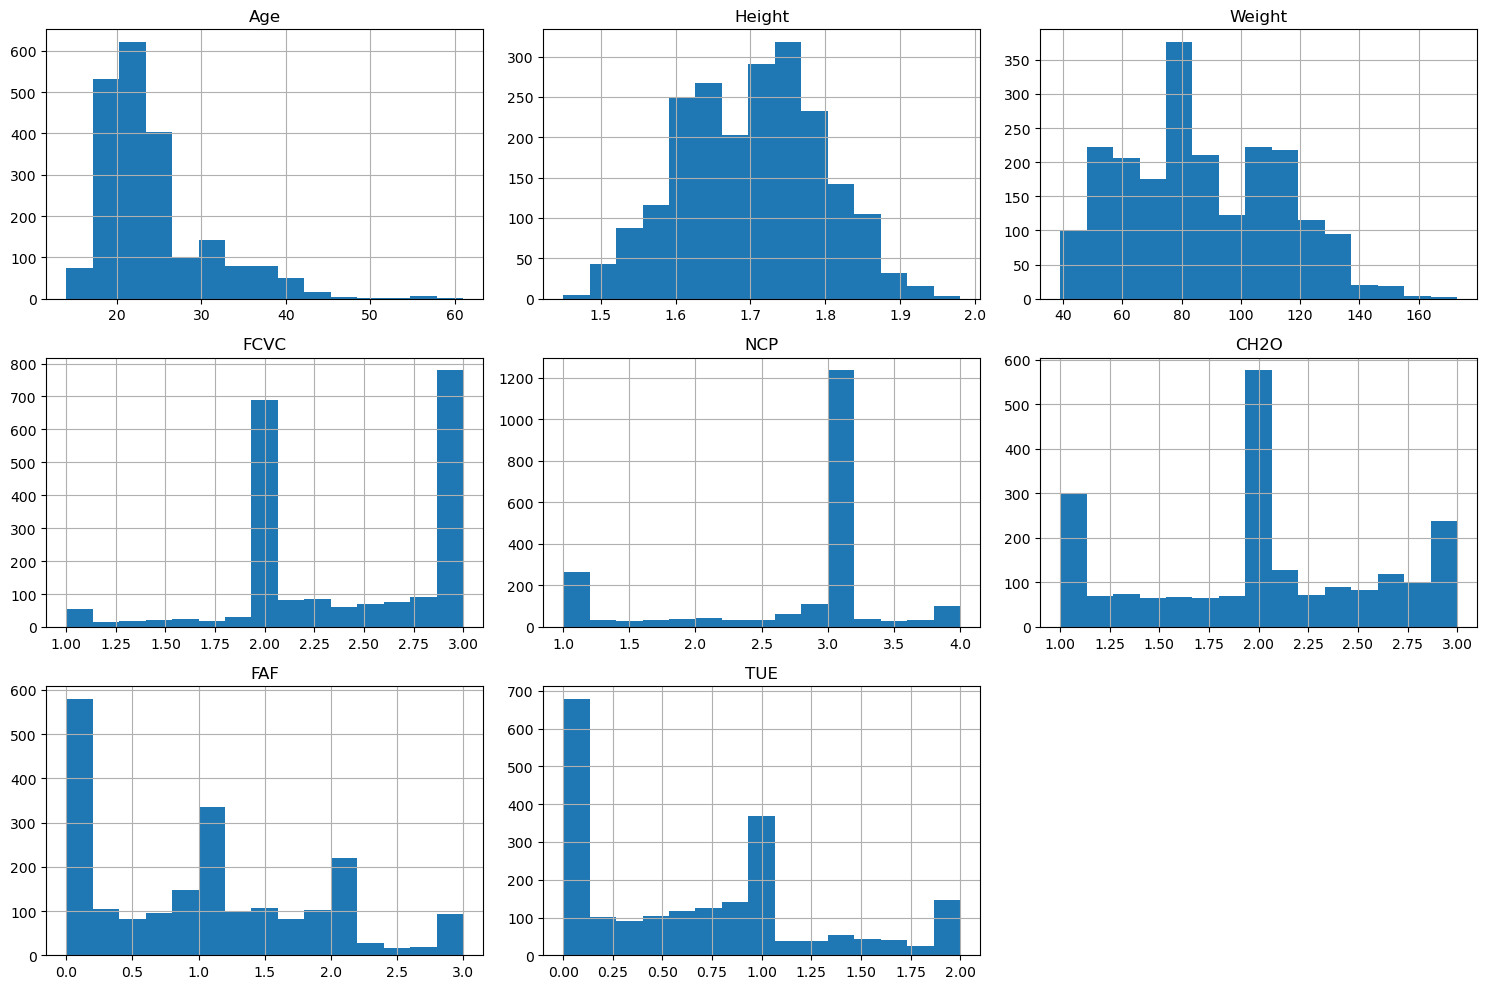

In [15]:
original_data.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

Многомерные графики: график корреляционной матрицы

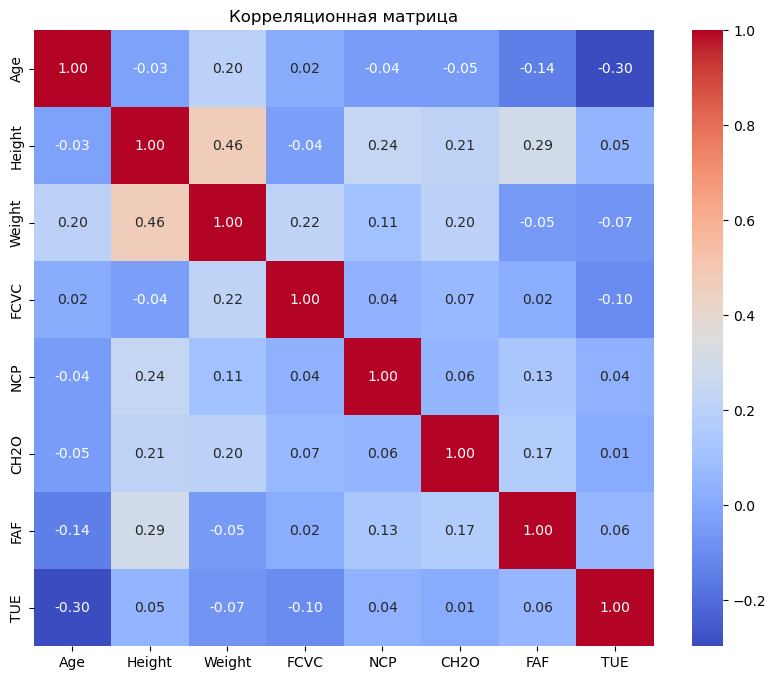

In [16]:
numeric_data = original_data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица")
plt.show()

Многомерные графики: матрица диаграммы рассеяния

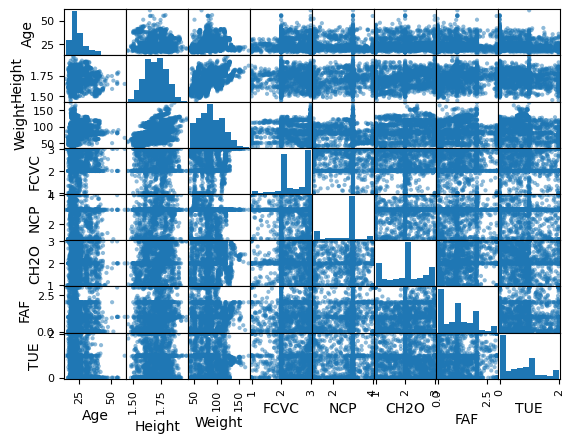

In [17]:
scatter_matrix(original_data)
plt.show()

Из полученных графиков «исходного» массива видно, что данные не полные, поэтому переходим к оцифровке текстовых атрибутов и в дальнейшем будем работать с ними как с исходным массивом.

### 3.g). Приведение текстовых признаков к числовому виду.

In [18]:
#                                                     ОЦИФРОВКА ТЕКСТОВЫХ АТРИБУТОВ
# Фильтрация нечисловых (object) столбцов
object_columns = clone_data.select_dtypes(include=['object'])

# Вывод типов ответов и их количества для каждого нечислового столбца
for column in object_columns.columns:
    print(f"Column: {column}")
    print(object_columns[column].value_counts())
    print()
print("\n")

# Определение порядка для оцифровки
encoder = OrdinalEncoder(categories=[
    ['Female', 'Male'],  # Gender
    ['no', 'yes'],       # family_history_with_overweight
    ['no', 'yes'],       # FAVC
    ['no', 'Sometimes', 'Frequently', 'Always'],  # CAEC
    ['no', 'yes'],       # SMOKE
    ['no', 'yes'],       # SCC
    ['no', 'Sometimes', 'Frequently', 'Always'],  # CALC
    ['Walking', 'Bike', 'Motorbike', 'Public_Transportation', 'Automobile'],  # MTRANS
    ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']  # NObeyesdad
])

# Оцифровка данных
encoded_data = encoder.fit_transform(clone_data[['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']])
# Преобразование обратно в DataFrame
encoded_data = pd.DataFrame(encoded_data, columns=['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad'])

# Удаление старых текстовых столбцов из оригинального DataFrame
clone_data = clone_data.drop(columns=['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad'])

# Объединение с остальными столбцами оригинального DataFrame
full_original_data = pd.concat([clone_data.reset_index(drop=True), encoded_data.reset_index(drop=True)], axis=1)

# Выводим результат
print(full_original_data.head())

Column: Gender
Gender
Male      1068
Female    1043
Name: count, dtype: int64

Column: family_history_with_overweight
family_history_with_overweight
yes    1726
no      385
Name: count, dtype: int64

Column: FAVC
FAVC
yes    1866
no      245
Name: count, dtype: int64

Column: CAEC
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64

Column: SMOKE
SMOKE
no     2067
yes      44
Name: count, dtype: int64

Column: SCC
SCC
no     2015
yes      96
Name: count, dtype: int64

Column: CALC
CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

Column: MTRANS
MTRANS
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64

Column: NObeyesdad
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Lev

### 3.h). Анализ набора данных после преобразования категориальных признаковы

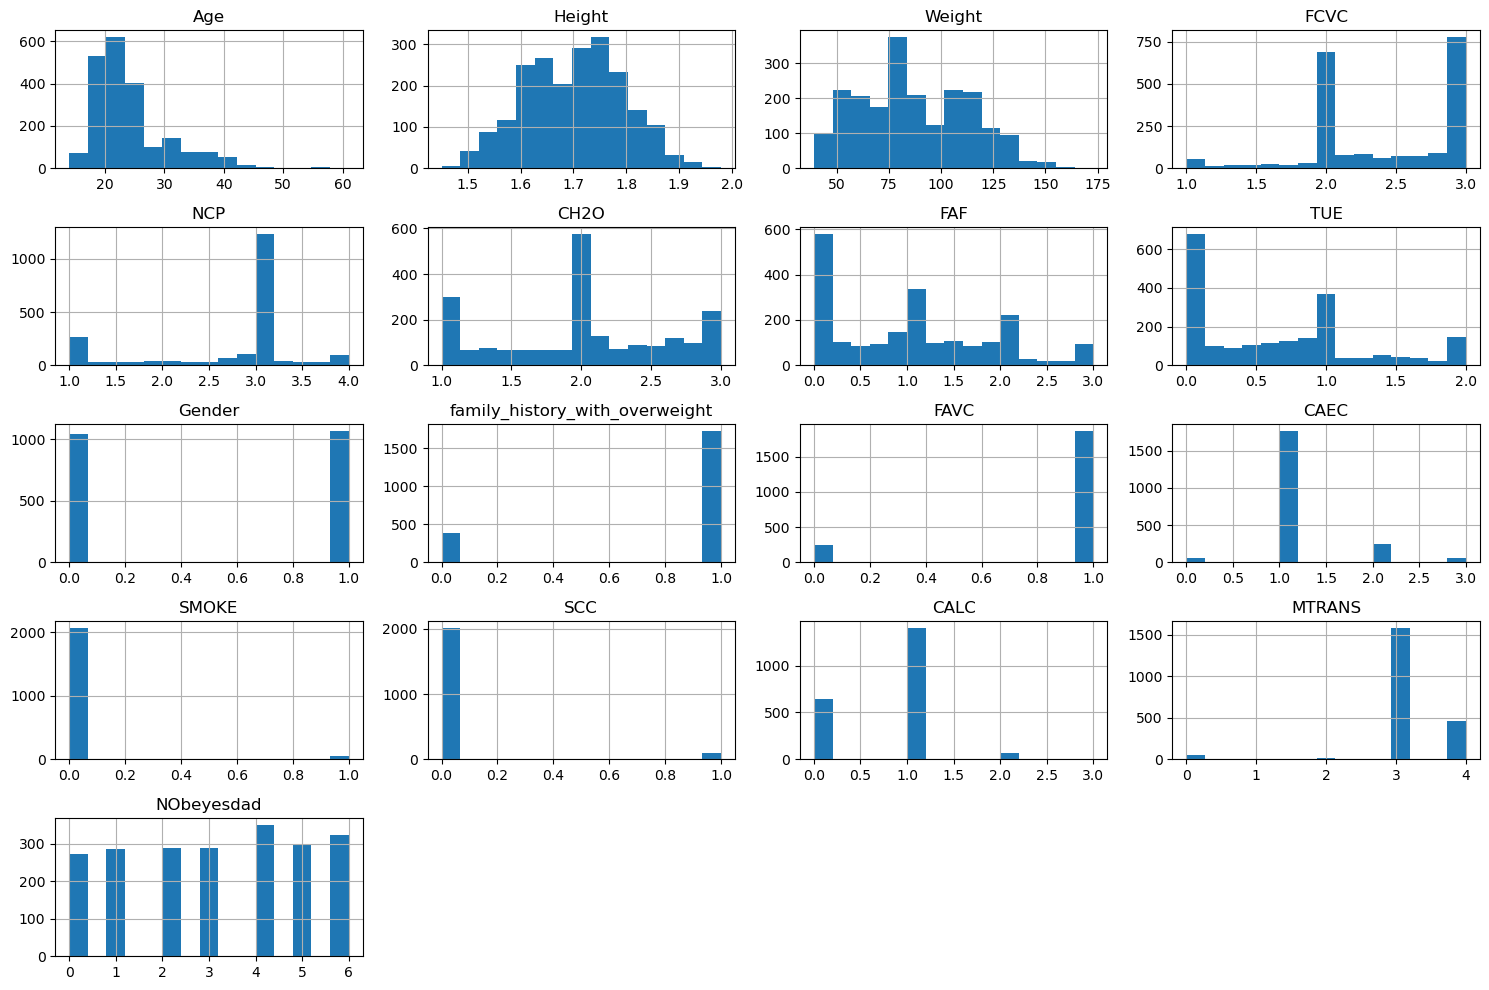

In [19]:
# Одномерные графики (гистограммы для всех числовых атрибутов)
full_original_data.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

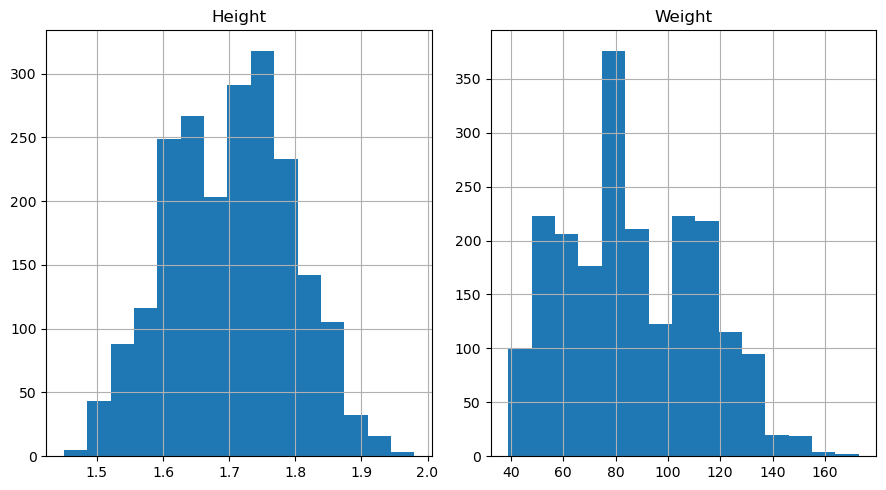

In [20]:
# На основе исходных данныех делаем специальный набор из двух атрибутов и сохраняем его в новую переменную
special_double_data = full_original_data[["Height", "Weight"]]
special_double_data.hist(bins=15, figsize=(9, 5))
plt.tight_layout()
plt.show()

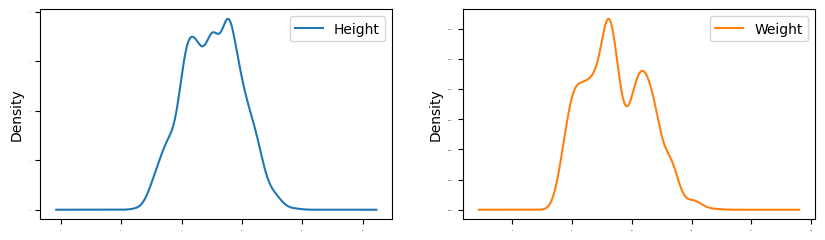

In [21]:
# Одномерные графики (плотности) для набора из двух атрибутов
special_double_data.plot(kind='density', subplots=True, layout=(2,2), sharex=False, legend=True, fontsize=1, figsize=(10,6))
plt.show()

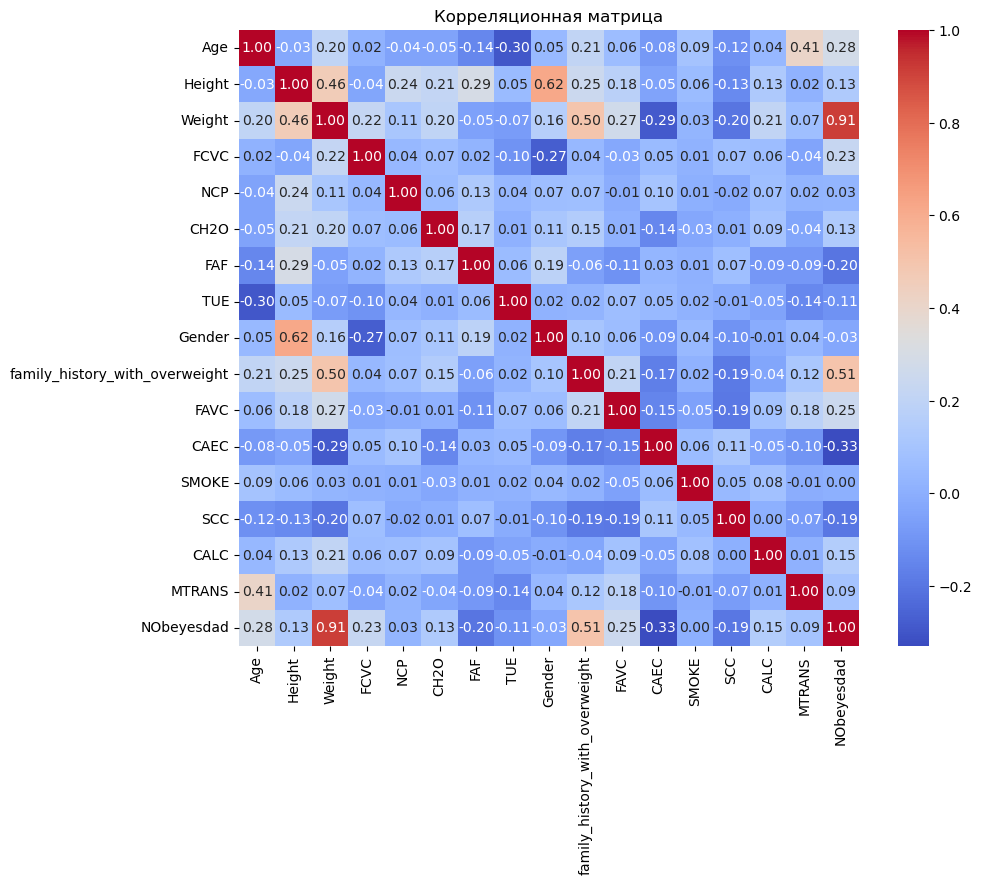

In [22]:
# Многомерные графики: график корреляционной матрицы
# Анализ корреляционной зависимости
numeric_data = full_original_data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица")
plt.show()

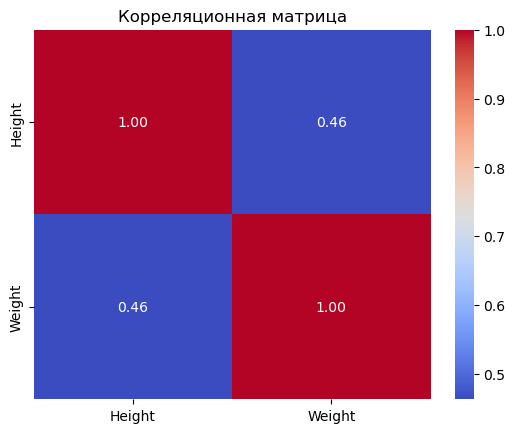

In [23]:
# Для нашей выборки двух атрибутов
correlation_matrix = special_double_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица")
plt.show()

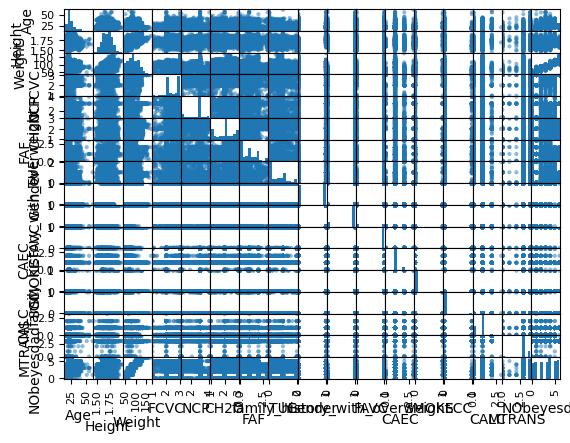

In [24]:
# Многомерные графики: матрица диаграммы рассеяния
scatter_matrix(full_original_data)
plt.show()

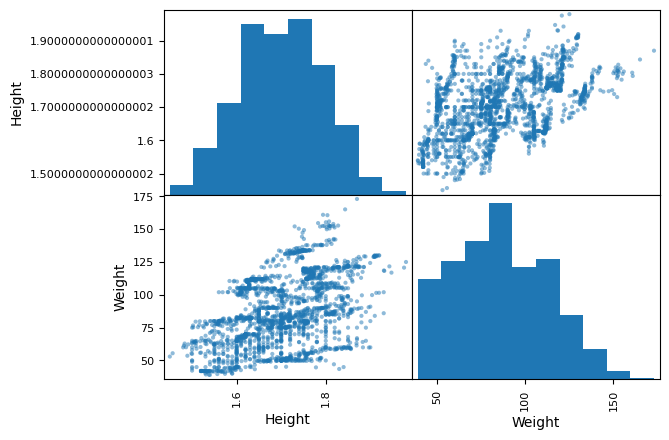

In [25]:
# Для нашей выборки двух атрибутов
scatter_matrix(special_double_data)
plt.show()

# 3.2 Поиск корреляционной зависимости между признаками

In [26]:
# Kоэффициент корреляции Пирсона для исходных
print("\n Kоэффициент корреляции Пирсона:")
attributes = ["NObeyesdad", "Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE",
              "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]
numeric_data_32 = full_original_data[attributes]
correlation_matrix_32 = numeric_data_32.corr()
print("Корреляционная матрица для атрибутов xxx:")
print(correlation_matrix_32)


 Kоэффициент корреляции Пирсона:
Корреляционная матрица для атрибутов xxx:
                                NObeyesdad    Age  Height  Weight   FCVC  \
NObeyesdad                           1.000  0.283   0.134   0.913  0.228   
Age                                  0.283  1.000  -0.026   0.203  0.016   
Height                               0.134 -0.026   1.000   0.463 -0.038   
Weight                               0.913  0.203   0.463   1.000  0.216   
FCVC                                 0.228  0.016  -0.038   0.216  1.000   
NCP                                  0.027 -0.044   0.244   0.107  0.042   
CH2O                                 0.133 -0.045   0.213   0.201  0.068   
FAF                                 -0.200 -0.145   0.295  -0.051  0.020   
TUE                                 -0.108 -0.297   0.052  -0.072 -0.101   
Gender                              -0.031  0.048   0.618   0.162 -0.275   
family_history_with_overweight       0.505  0.206   0.248   0.497  0.040   
FAVC        

### 3.d). Поиск корреляционной зависимости между признаками
Выбираем "несколько многообещающих атрибутов", берём те у которых влияние больше +-0.2

NObeyesdad                        1.000
Weight                            0.913
family_history_with_overweight    0.505
Age                               0.283
FAVC                              0.248
FCVC                              0.228
CALC                              0.152
Height                            0.134
CH2O                              0.133
MTRANS                            0.094
NCP                               0.027
SMOKE                             0.003
Gender                           -0.031
TUE                              -0.108
SCC                              -0.195
FAF                              -0.200
CAEC                             -0.329
Name: NObeyesdad, dtype: float64


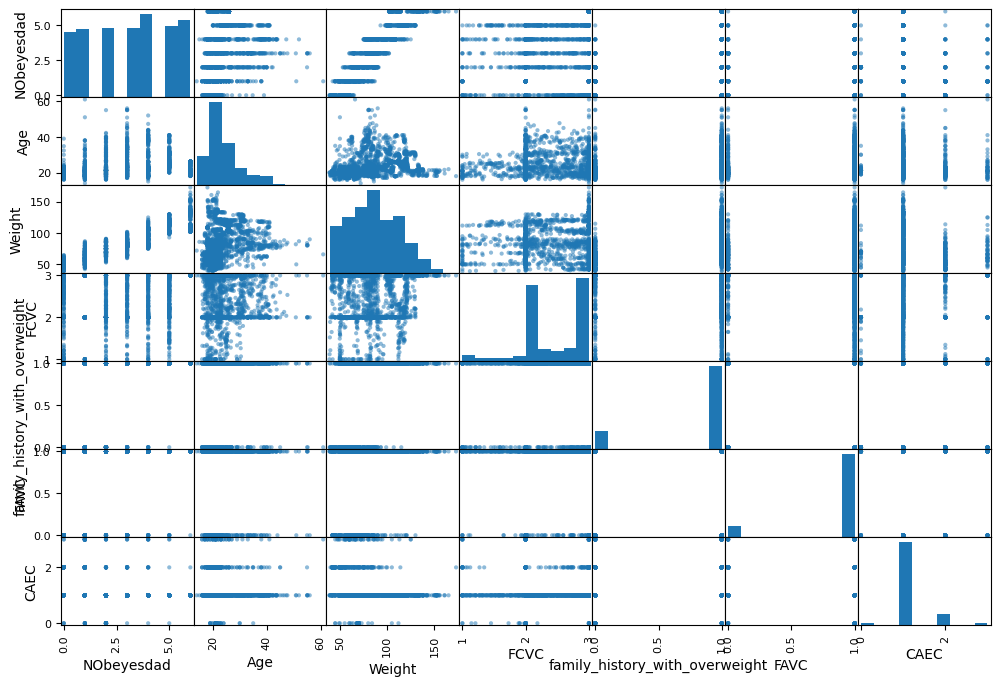

In [27]:
print(correlation_matrix_32["NObeyesdad"].sort_values(ascending=False))
attributes = ["NObeyesdad", "Age", "Weight", "FCVC", "family_history_with_overweight", "FAVC", "CAEC"]
scatter_matrix(full_original_data[attributes], figsize=(12,8))
plt.show()

Выведем диаграмму рассеяния для двух самых взаимосвязанных атрибутов

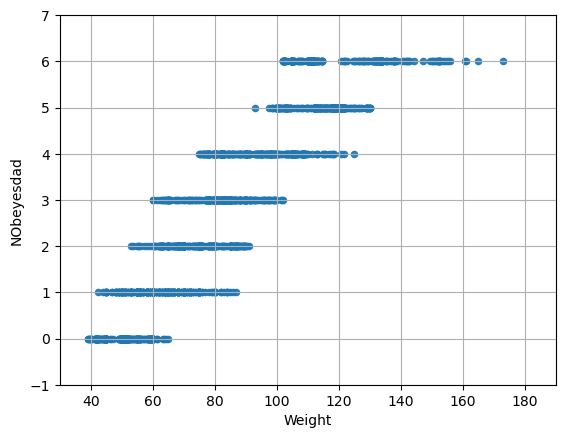

In [28]:
full_original_data.plot(kind="scatter", x="Weight", y="NObeyesdad", alpha=0.9)
plt.axis([30, 190, -1, 7])
plt.xlabel('Weight')
plt.ylabel('NObeyesdad')
plt.grid()
plt.show()

### 3.f). Отбор существенных (информативных) признаков

In [29]:
set_of_essential_features = full_original_data.copy()
X = set_of_essential_features.drop(columns=['NObeyesdad'])
y = set_of_essential_features['NObeyesdad']  
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
# Применение SelectKBest
k = 10  # Количество лучших признаков (можно выбрать любое число)
selector = SelectKBest(score_func=f_classif, k=k)  
X_train_selected = selector.fit_transform(X_train, y_train)
fit = selector.fit(X_train, y_train)
# Получение выбранных признаков
selected_features = X_train.columns[selector.get_support()]
# Вывод выбранных признаков
print("Выбранные признаки:")
print(selected_features)

Выбранные признаки:
Index(['Age', 'Height', 'Weight', 'FCVC', 'Gender',
       'family_history_with_overweight', 'FAVC', 'CAEC', 'CALC', 'MTRANS'],
      dtype='object')


In [30]:
dfscores = pd.Series(fit.scores_)
dfcolumns = pd.Series(X_train.columns)
featureScores = pd.concat([dfcolumns,dfscores],keys=["Column","Score"],axis=1)
featureScores.sort_values("Score", ascending = False)

,Column,Score
2,Weight,1575.752
8,Gender,127.504
9,family_history_with_overweight,112.699
3,FCVC,88.319
0,Age,66.117
11,CAEC,62.145
10,FAVC,34.754
1,Height,29.059
14,CALC,27.679
15,MTRANS,22.422


Отметим, что наиболее информативным с большим отрывом является признак Weight, в значительно меньшей мере Gender и family_history_with_overweight. Замыкают список TUE и SMOKE

### 3.e). Создание изменённого набора данных
Добавим признак на основании комбинации атрибутов (индекс массы тела), уберём два менее информативных признака (SMOKE, NCP).

In [31]:
# Создание новой переменной и атрибута индекса массы тела
modified_full_original_data = full_original_data.copy()
modified_full_original_data["IMT"] = modified_full_original_data["Weight"] / (modified_full_original_data["Height"] * modified_full_original_data["Height"])
# Удаление атрибута курения и колличества порций в день (признаки с низкой информативностью)
modified_full_original_data = modified_full_original_data.drop(columns=["SMOKE", "NCP"])

Матрица корреляции для модифицированного набора данных:

In [32]:
# Вывод в консоль полученного набора
modified_numeric_data = modified_full_original_data.select_dtypes(include=['float64', 'int64'])
modified_correlation_matrix = modified_numeric_data.corr()
modified_correlation_matrix

,Age,Height,Weight,FCVC,CH2O,FAF,TUE,Gender,family_history_with_overweight,FAVC,CAEC,SCC,CALC,MTRANS,NObeyesdad,IMT
Age,1.000,-0.026,0.203,0.016,-0.045,-0.145,-0.297,0.048,0.206,0.064,-0.084,-0.116,0.044,0.410,0.283,0.244
Height,-0.026,1.000,0.463,-0.038,0.213,0.295,0.052,0.618,0.248,0.178,-0.049,-0.134,0.130,0.017,0.134,0.132
Weight,0.203,0.463,1.000,0.216,0.201,-0.051,-0.072,0.162,0.497,0.272,-0.287,-0.202,0.207,0.071,0.913,0.935
FCVC,0.016,-0.038,0.216,1.000,0.068,0.020,-0.101,-0.275,0.040,-0.027,0.055,0.072,0.061,-0.041,0.228,0.264
CH2O,-0.045,0.213,0.201,0.068,1.000,0.167,0.012,0.108,0.147,0.010,-0.145,0.008,0.091,-0.038,0.133,0.144
FAF,-0.145,0.295,-0.051,0.020,0.167,1.000,0.059,0.190,-0.057,-0.108,0.030,0.074,-0.087,-0.086,-0.200,-0.178
TUE,-0.297,0.052,-0.072,-0.101,0.012,0.059,1.000,0.017,0.023,0.068,0.049,-0.011,-0.046,-0.142,-0.108,-0.100
Gender,0.048,0.618,0.162,-0.275,0.108,0.190,0.017,1.000,0.103,0.065,-0.092,-0.103,-0.008,0.041,-0.031,-0.053
family_history_with_overweight,0.206,0.248,0.497,0.040,0.147,-0.057,0.023,0.103,1.000,0.208,-0.170,-0.185,-0.037,0.116,0.505,0.484
FAVC,0.064,0.178,0.272,-0.027,0.010,-0.108,0.068,0.065,0.208,1.000,-0.150,-0.191,0.090,0.181,0.248,0.246


Выведем корреляционную матрицу в графическом виде.

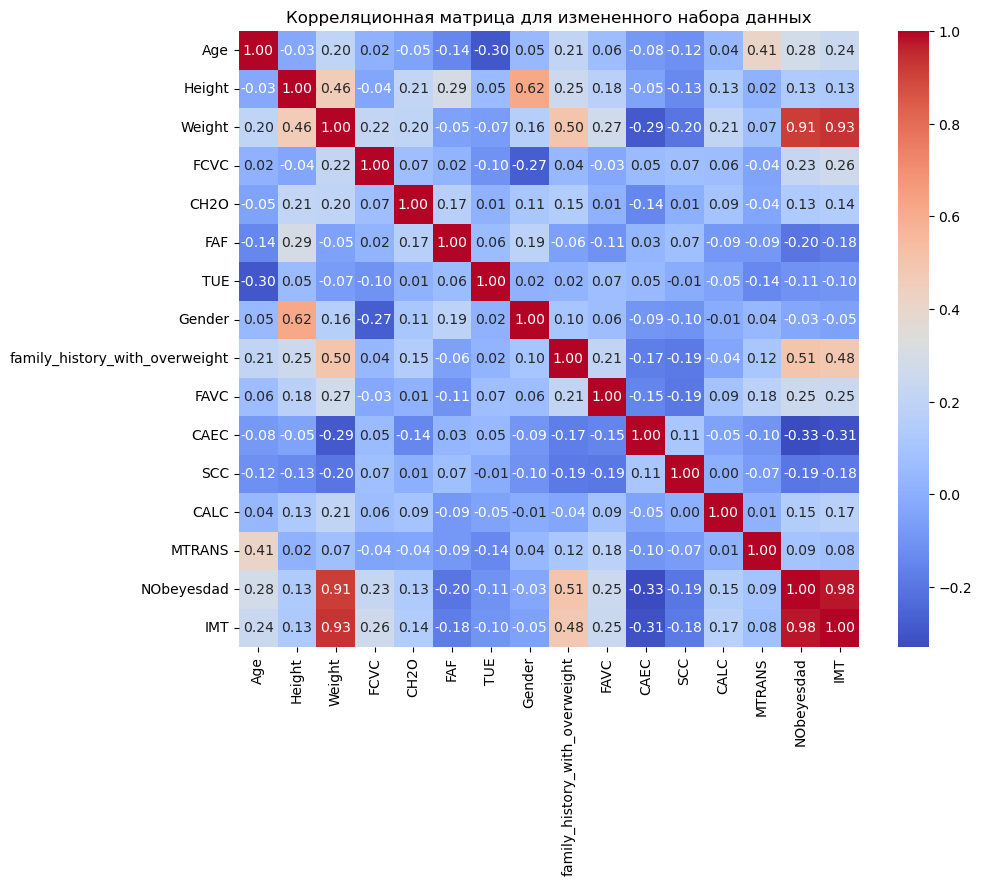

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(modified_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица для измененного набора данных")
plt.show()

# Преобразование данных Min-max масштабирование
Выполняем масштабирование исходных данных, создаем экземпляр MinMaxScaler.

Копируем данные в массив, преобразуем его и сохраним в новую переменную.

In [34]:
Min_Max_fod = full_original_data.copy()
scaler = MinMaxScaler()

# Выбор столбцов для масштабирования (все столбцы, кроме целевой переменной)
features = Min_Max_fod.drop(columns=['NObeyesdad'])
# Применение MinMaxScaler
scaled_features = scaler.fit_transform(features)
# Преобразование обратно в DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
# Объединение масштабированных признаков с целевой переменной
Min_Max_full_original_data = pd.concat([scaled_df, Min_Max_fod['NObeyesdad']], axis=1)

# Вывод первых нескольких строк финального DataFrame
print(Min_Max_full_original_data.head())

     Age  Height  Weight  FCVC    NCP  CH2O    FAF  TUE  Gender  \
0  0.149   0.321   0.187   0.5  0.667   0.5  0.000  0.5     0.0   
1  0.149   0.132   0.127   1.0  0.667   1.0  1.000  0.0     0.0   
2  0.191   0.660   0.284   0.5  0.667   0.5  0.667  0.5     1.0   
3  0.277   0.660   0.358   1.0  0.667   0.5  0.667  0.0     1.0   
4  0.170   0.623   0.379   0.5  0.000   0.5  0.000  0.0     1.0   

   family_history_with_overweight  FAVC   CAEC  SMOKE  SCC   CALC  MTRANS  \
0                             1.0   0.0  0.333    0.0  0.0  0.000    0.75   
1                             1.0   0.0  0.333    1.0  1.0  0.333    0.75   
2                             1.0   0.0  0.333    0.0  0.0  0.667    0.75   
3                             0.0   0.0  0.333    0.0  0.0  0.667    0.00   
4                             0.0   0.0  0.333    0.0  0.0  0.333    0.75   

   NObeyesdad  
0         1.0  
1         1.0  
2         1.0  
3         2.0  
4         3.0  


Повторим то же самое для расширенного набора данных

In [35]:
# Выполняем масштабирование исходных данных, создаем экземпляр MinMaxScaler
# Копируем данные в массив, потом его преобразуем и сохраним в новую переменную
Min_Max_fod_2 = modified_full_original_data.copy()
scaler = MinMaxScaler()

# Выбор столбцов для масштабирования (все столбцы, кроме целевой переменной)
features = Min_Max_fod_2.drop(columns=['NObeyesdad'])
# Применение MinMaxScaler
scaled_features = scaler.fit_transform(features)
# Преобразование обратно в DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
# Объединение масштабированных признаков с целевой переменной
Min_Max_modified_full_original_data = pd.concat([scaled_df, Min_Max_fod_2['NObeyesdad']], axis=1)

# Вывод первых нескольких строк финального DataFrame
print(Min_Max_modified_full_original_data.head())

     Age  Height  Weight  FCVC  CH2O    FAF  TUE  Gender  \
0  0.149   0.321   0.187   0.5   0.5  0.000  0.5     0.0   
1  0.149   0.132   0.127   1.0   1.0  1.000  0.0     0.0   
2  0.191   0.660   0.284   0.5   0.5  0.667  0.5     1.0   
3  0.277   0.660   0.358   1.0   0.5  0.667  0.0     1.0   
4  0.170   0.623   0.379   0.5   0.5  0.000  0.0     1.0   

   family_history_with_overweight  FAVC   CAEC  SCC   CALC  MTRANS    IMT  \
0                             1.0   0.0  0.333  0.0  0.000    0.75  0.301   
1                             1.0   0.0  0.333  1.0  0.333    0.75  0.297   
2                             1.0   0.0  0.333  0.0  0.667    0.75  0.285   
3                             0.0   0.0  0.333  0.0  0.667    0.00  0.366   
4                             0.0   0.0  0.333  0.0  0.333    0.75  0.406   

   NObeyesdad  
0         1.0  
1         1.0  
2         1.0  
3         2.0  
4         3.0  


## Выделение обучающей, проверочной (валидационной) и тестовой выборки данных.
разделяем наборы данных на обучающую, проверочную (валидационную) и тестовую выборки т.е. 80% исходного набора - обучающая, 20% тестовая на втором шаге из обучающей выборки (та что 80%) выделяем обучающую и валидационную, также 80% и 20%. Получается наше первое значение обучающей выборки перезаписывается и становиться 64% от исходного набора (того который делим) валидационная выборка - 16%, а тестовая по прежнему 20%, её мы не трогали. Так делаем для всех 4 наборов.

Сначала выполняем его для исходного набора данных "full_original_data"

In [36]:
X = full_original_data.drop(columns=['NObeyesdad'])  
y = full_original_data['NObeyesdad']  

# Делим данные на обучающую и тестовую выборки (80% на обучение и 20% на тест)
X_train_full_original_data, X_test_full_original_data, y_train_full_original_data, y_test_full_original_data = (
    train_test_split(X, y, test_size=0.2, random_state=30))
# Теперь разделим обучающую выборку на обучающую и валидационную (80% на обучение и 20% на валидацию)
X_train_full_original_data, X_val_full_original_data, y_train_full_original_data, y_val_full_original_data = (
    train_test_split(X_train_full_original_data, y_train_full_original_data, test_size=0.2, random_state=30))

# Вывод размеров выборок
print(f"Размер обучающей выборки: {X_train_full_original_data.shape[0]}")
print(f"Размер валидационной выборки: {X_val_full_original_data.shape[0]}")
print(f"Размер тестовой выборки: {X_test_full_original_data.shape[0]}")

Размер обучающей выборки: 1350
Размер валидационной выборки: 338
Размер тестовой выборки: 423


Повторим то же самое для преобразованного набора данных "modified_full_original_data"

In [37]:
X = modified_full_original_data.drop(columns=['NObeyesdad'])  
y = modified_full_original_data['NObeyesdad']  

# Делим данные на обучающую и тестовую выборки (80% на обучение и 20% на тест)
X_train_modified_full_original_data, X_test_modified_full_original_data, y_train_modified_full_original_data, y_test_modified_full_original_data = (
    train_test_split(X, y, test_size=0.2, random_state=30))
# Теперь разделим обучающую выборку на обучающую и валидационную (80% на обучение и 20% на валидацию)
X_train_modified_full_original_data, X_val_modified_full_original_data, y_train_modified_full_original_data, y_val_modified_full_original_data = (
    train_test_split(X_train_modified_full_original_data, y_train_modified_full_original_data, test_size=0.2, random_state=30))

для масштабированного исходного набора Min_Max_full_original_data

In [38]:
X = Min_Max_full_original_data.drop(columns=['NObeyesdad'])  
y = Min_Max_full_original_data['NObeyesdad']  

# Делим данные на обучающую и тестовую выборки (80% на обучение и 20% на тест)
X_train_Min_Max_full_original_data, X_test_Min_Max_full_original_data, y_train_Min_Max_full_original_data, y_test_Min_Max_full_original_data = (
    train_test_split(X, y, test_size=0.2, random_state=30))
# Теперь разделим обучающую выборку на обучающую и валидационную (80% на обучение и 20% на валидацию)
X_train_Min_Max_full_original_data, X_val_Min_Max_full_original_data, y_train_Min_Max_full_original_data, y_val_Min_Max_full_original_data = (
    train_test_split(X_train_Min_Max_full_original_data, y_train_Min_Max_full_original_data, test_size=0.2, random_state=30))

для масштабированного измененного набора Min_Max_modified_full_original_data

In [39]:
X = Min_Max_modified_full_original_data.drop(columns=['NObeyesdad'])  
y = Min_Max_modified_full_original_data['NObeyesdad']  

# Делим данные на обучающую и тестовую выборки (80% на обучение и 20% на тест)
X_train_Min_Max_modified_full_original_data, X_test_Min_Max_modified_full_original_data, y_train_Min_Max_modified_full_original_data, y_test_Min_Max_modified_full_original_data = (
    train_test_split(X, y, test_size=0.2, random_state=30))
# Теперь разделим обучающую выборку на обучающую и валидационную (80% на обучение и 20% на валидацию)
X_train_Min_Max_modified_full_original_data, X_val_Min_Max_modified_full_original_data, y_train_Min_Max_modified_full_original_data, y_val_Min_Max_modified_full_original_data = (
    train_test_split(X_train_Min_Max_modified_full_original_data, y_train_Min_Max_modified_full_original_data, test_size=0.2, random_state=30))

In [40]:
datasets = [
    (X_train_full_original_data, y_train_full_original_data, X_val_full_original_data, y_val_full_original_data),
    (X_train_modified_full_original_data, y_train_modified_full_original_data, X_val_modified_full_original_data, y_val_modified_full_original_data),
    (X_train_Min_Max_full_original_data, y_train_Min_Max_full_original_data, X_val_Min_Max_full_original_data, y_val_Min_Max_full_original_data),
    (X_train_Min_Max_modified_full_original_data, y_train_Min_Max_modified_full_original_data, X_val_Min_Max_modified_full_original_data, y_val_Min_Max_modified_full_original_data)
]

Массив имён наборов данных. Используем для конвертации индексов в названия.

In [41]:
dataset_names = [ "original", "extended", "original_scaled", "extended_scaled" ]

### 5.1). Создание и обучение нейросетевой модели
Для каждого набора создадим нейронную сеть с 4 слоями (включая входной) и произведём её обучение.

По варианту: Рекуррентная GRU нейросетевая модель.

In [42]:
# для одинакового создания весов при обучении и прогнозирования модели
set_random_seed(30)

gru_initial_results = []
reshaped_data = []

# Цикл по наборам данных
for i, (X_train, y_train, X_val, y_val) in enumerate(datasets):
    X = X_train.drop('NObeyesdad', axis=1, errors='ignore').values
    yTFOD = y_train.to_frame()
    y = to_categorical(yTFOD['NObeyesdad'].values)      
    xV = X_val.values  
    yTFOD_V = y_val.to_frame()
    yV = to_categorical(yTFOD_V['NObeyesdad'].values)

    print(f'Shape: {y.shape[1]}')
    # Создание модели
    model = Sequential()
    model.add(Input(shape=(1, X.shape[1])))
    model.add(GRU(64, activation='relu', return_sequences=True ))
    model.add(GRU(32, activation='relu'))
    # Дополнительный плотный слой для повышения точности
    model.add(Dense(4*y.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(tf.keras.layers.Flatten())
    model.add(Dense(y.shape[1], activation='softmax'))  

    # Компиляция модели
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Изменение формы входных данных для GRU
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  
    xV_reshaped = xV.reshape((xV.shape[0], 1, xV.shape[1]))  

    reshaped_data.append((X_reshaped, xV_reshaped))

    # Обучение модели
    history = model.fit(X_reshaped, y, epochs=50, batch_size=32, validation_data=(xV_reshaped, yV), shuffle=False)

    # Оценка качества модели на валидационной выборке
    y_val_pred_prob = model.predict(xV_reshaped)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)

    # Преобразуем y_val для сравнения
    y_val_encoded = np.argmax(yV, axis=1)

    # Метрики оценки качества
    accuracy = accuracy_score(y_val_encoded, y_val_pred)
    balanced_accuracy = balanced_accuracy_score(y_val_encoded, y_val_pred)
    f1_macro = f1_score(y_val_encoded, y_val_pred, average='macro')
    f1_micro = f1_score(y_val_encoded, y_val_pred, average='micro')

    # Запишем результаты в массив для дальнейшего использования
    gru_initial_results.append({ "index":i, "accuracy":accuracy, "balanced_accuracy":balanced_accuracy, "f1_macro":f1_macro, "f1_micro":f1_micro })

    print(f'Dataset {i + 1}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
    print(f'F1 Score (Macro): {f1_macro:.4f}')
    print(f'F1 Score (Micro): {f1_micro:.4f}')

Shape: 7
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1817 - loss: 2.9702 - val_accuracy: 0.2485 - val_loss: 1.8199
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2800 - loss: 1.6991 - val_accuracy: 0.4290 - val_loss: 1.4244
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4803 - loss: 1.2791 - val_accuracy: 0.5680 - val_loss: 1.0232
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5679 - loss: 0.9781 - val_accuracy: 0.6065 - val_loss: 0.9065
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6075 - loss: 0.8868 - val_accuracy: 0.6154 - val_loss: 0.8626
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6257 - loss: 0.8408 - val_accuracy: 0.6716 - val_loss: 0.7888
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6650 - loss: 0.7803 - val_accuracy: 0.7012 - val_loss: 0.7527
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7032 - loss: 0.7311 - val_accuracy: 0.7308 - 

Сведём характеристики точности полученных моделей в единую табличку

In [83]:
# Вспомогательная функция отражения результатов в виде дата фрейма
def GetResultsDataFrame(results_array):
    model_dataset = []
    model_accuracy = []
    model_balanced_acc = []
    model_f1_macro = []
    model_f1_micro = []
    
    for result in results_array:
        model_dataset.append(dataset_names[result["index"]]),
        model_accuracy.append(result["accuracy"]),
        model_balanced_acc.append(result["balanced_accuracy"]),
        model_f1_macro.append(result["f1_macro"]),
        model_f1_micro.append(result["f1_micro"]),
        
    df_dict = {
        "Набор данных":model_dataset, 
        "Accuracy":model_accuracy, 
        "Balanced Accuracy":model_balanced_acc, 
        "F1 (Macro)":model_f1_macro,
        "F1 (Micro)":model_f1_micro
    }
    
    model_df = pd.DataFrame(df_dict)
    return model_df

# Вспомогательная функция получения имени науилучшего набора данных
def GetBestDatasetName(results_array):
    best = max(gru_initial_results, key=lambda dataset: dataset["accuracy"])
    return dataset_names[gru_initial_results.index(best)]

def GetBestDataset(results_array):
    best = max(gru_initial_results, key=lambda dataset: dataset["accuracy"])
    return best

In [84]:
pd.set_option('display.float_format', str)
initial_model_df = GetResultsDataFrame(gru_initial_results)
initial_model_df

,Набор данных,Accuracy,Balanced Accuracy,F1 (Macro),F1 (Micro)
0,original,0.8668639053254438,0.869302534568995,0.8681599883159468,0.8668639053254438
1,extended,0.9289940828402367,0.9300133173347777,0.9305140280181383,0.9289940828402367
2,original_scaled,0.9556213017751479,0.9566223579646441,0.9569248408453609,0.9556213017751479
3,extended_scaled,0.9615384615384616,0.9628679243857975,0.962868602231716,0.9615384615384616


In [91]:
nn_best_dataset = GetBestDataset(gru_initial_results)
nn_best_dataset_name = GetBestDatasetName(gru_initial_results)
print(f"Best dataset: {nn_best_dataset_name}")

Best dataset: extended_scaled


In [90]:
print(f'Accuracy for best dataset: {nn_best_dataset["accuracy"]:.4f}')

Accuracy for best dataset: 0.9615


Лучший результат по точности (Accuracy) модель показывает для расширенного масштабированного набора - 96.15%

### 5.2). Подготовка модели на базе градиентного бустинга
Для каждого из наборов данных построим классификационную модель на базе градиентного бустинга, проверим её работы на валидационной выборе, и подсчитаем характеристики её точности (accuracy, balanced accruacy, f1) для данного случая.

In [46]:
gb_initial_results = []

for i, (X_train, y_train, X_val, y_val) in enumerate(datasets):
    # Проверка типа y_train и извлечение целевой переменной
    if isinstance(y_train, pd.Series):
        y = y_train.values  # Если это Series
    else:
        print(f"Warning: Expected Series for y_train in dataset {i + 1}.")
        continue  

    if isinstance(y_val, pd.Series):
        yV = y_val.values  
    else:
        print(f"Warning: Expected Series for y_val in dataset {i + 1}.")
        continue  

    # Подготовка данных
    X = X_train.drop('NObeyesdad', axis=1, errors='ignore').values
    xV = X_val.drop('NObeyesdad', axis=1, errors='ignore').values  

    # Создание и обучение модели
    model = xgb.XGBClassifier()
    model.fit(X, y)

    # Прогнозирование на валидационной выборке
    y_val_pred = model.predict(xV)

    # Метрики оценки качества
    accuracy = accuracy_score(yV, y_val_pred)
    balanced_accuracy = balanced_accuracy_score(yV, y_val_pred)
    f1_macro = f1_score(yV, y_val_pred, average='macro')
    f1_micro = f1_score(yV, y_val_pred, average='micro')

    # Записываем характеристики точности для каждого из наборов данных.
    gb_initial_results.append({
        'index':i,
        'accuracy':accuracy,
        'balanced_accuracy':balanced_accuracy,
        'f1_macro':f1_macro,
        'f1_micro':f1_micro
    })

Выведем результаты для моделей на каждом из наборов данных, определим из них тот, где точность наивысшая.

In [47]:
gb_model_df = GetResultsDataFrame(gb_initial_results)
gb_model_df

,Набор данных,Accuracy,Balanced Accuracy,F1 (Macro),F1 (Micro)
0,original,0.9763313609467456,0.9760343863418866,0.9765758648840972,0.9763313609467456
1,extended,0.9822485207100592,0.9832000433023451,0.9831607415833165,0.9822485207100592
2,original_scaled,0.9763313609467456,0.9760343863418866,0.9765758648840972,0.9763313609467456
3,extended_scaled,0.9822485207100592,0.9832000433023451,0.9831607415833165,0.9822485207100592


In [48]:
print(f"Best dataset: {GetBestDatasetName(gb_initial_results)}")

Best dataset: extended_scaled


Исходные модели показали наилучшие результаты для изменённого и изменённого масштабированного наборов данных (значения точности одинаковые). В таком случае, за лучший будем считать последний набор.

### 6). Для лучшей модели на лучшем наборе данных оценить качество на тестовом наборе.

Модель градиентного бустинга во всех случаях показывает лучшие результаты. Лучшим набором можем считать либо 2 (изменённый) либо 4 (изменённый масштабированный) - договорились считать 4. Проверим точность модели на **тестовой** выборке вместо валидационной.

In [49]:
X_train = X_train_Min_Max_modified_full_original_data
y_train = y_train_Min_Max_modified_full_original_data
X_test = X_test_Min_Max_modified_full_original_data
y_test = y_test_Min_Max_modified_full_original_data

# Проверка типа y_train и извлечение целевой переменной
if isinstance(y_train, pd.Series):
    y = y_train.values  
else:
    print("Warning: Expected Series for y_train.")

if isinstance(y_test, pd.Series):
    y_test_values = y_test.values  
else:
    print("Warning: Expected Series for y_test.")

# Подготовка данных 
X = X_train.drop('NObeyesdad', axis=1, errors='ignore').values
X_test_prepared = X_test.drop('NObeyesdad', axis=1, errors='ignore').values  

# Создание и обучение модели
model = xgb.XGBClassifier()
model.fit(X, y)

# Прогнозирование на тестовой выборке
y_test_pred = model.predict(X_test_prepared)

# Метрики оценки качества
best_non_optimized_accuracy = accuracy_score(y_test_values, y_test_pred)
best_non_optimized_balanced_accuracy = balanced_accuracy_score(y_test_values, y_test_pred)
best_non_optimized_f1_macro = f1_score(y_test_values, y_test_pred, average='macro')
best_non_optimized_f1_micro = f1_score(y_test_values, y_test_pred, average='micro')

print(f'Accuracy: {best_non_optimized_accuracy:.4f}')
print(f'Balanced Accuracy: {best_non_optimized_balanced_accuracy:.4f}')
print(f'F1 Score (Macro): {best_non_optimized_f1_macro:.4f}')
print(f'F1 Score (Micro): {best_non_optimized_f1_micro:.4f}')

Accuracy: 0.9905
Balanced Accuracy: 0.9903
F1 Score (Macro): 0.9902
F1 Score (Micro): 0.9905


На тестовой выборке модель показывает точность 99,05%, что выше, чем для валидационной.

### 7.1). Поиск лучших гиперпараметров нейросетевой модели на обучающей и валидационной выборках.

Для лучшей модели (4 набор данных) осуществляем поиск лучших гиперпараметров модели градиентного бустинга на обучающей и валидационной выборках.

Поиск осуществляем с помощью пакета Keras Tuner.

In [133]:
X_train = datasets[3][0]
y_train = datasets[3][1]
X_val = datasets[3][2]
y_val = datasets[3][3]

X = X_train.drop('NObeyesdad', axis=1, errors='ignore').values
yTFOD = y_train.to_frame()
y = to_categorical(yTFOD['NObeyesdad'].values)
xV = X_val.values
yTFOD_V = y_val.to_frame()
yV = to_categorical(yTFOD_V['NObeyesdad'].values)

# Изменение формы входных данных для GRU
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  
xV_reshaped = xV.reshape((xV.shape[0], 1, xV.shape[1]))  

#Xshape = datasets[3][0].shape[1]
#Xshape = X_reshaped.shape[0]
Xshape = X.shape[1]
Yshape = len(data.value_counts("NObeyesdad")) # кол-во уникальных значений целевого признака

print(f'{Xshape}, {Yshape}')


15, 7


Введём функцию конструирования модели по набору гиперпараметров

In [113]:
def BuildTuningModel(hp):
    # Создание модели
    model = Sequential()
    model.add(Input(shape=(1, X.shape[1])))
    model.add(GRU(hp.Choice('units_l1', [128, 64,32]), activation='relu', return_sequences=True ))
    model.add(GRU(hp.Choice('units_l2', [32,16,8]), activation='relu'))
    model.add(Dense(hp.Choice('units_dense', [Yshape*i for i in range(1,5)]), 
                    activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(y.shape[1], activation='softmax'))  

    # Компиляция модели
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Осуществим Grid-поиск лучшего набора гиперпараметров, по результатам возьмём лучшую модель.

**Важный момент**: параметр тюнера overwrite должен иметь значение true, чтобы при смене исходных характеристик модели не брались старые закешированные значения (веса для наборов гиперпараметров и т.д.).

In [123]:
set_random_seed(30)
#history = model.fit(X_reshaped, y, epochs=50, batch_size=32, validation_data=(xV_reshaped, yV), shuffle=False)

tuner = keras_tuner.GridSearch(hypermodel=BuildTuningModel, objective='val_accuracy', max_trials=50, overwrite=True)
#tuner = keras_tuner.Hyperband(hypermodel=BuildTuningModel, objective='accuracy', max_epochs=50, hyperband_iterations=3,overwrite=True)
#tuner = keras_tuner.RandomSearch(BuildTuningModel, objective='accuracy', max_trials=50, overwrite=True)
tuner.search(X_reshaped, y, epochs=50, validation_data=(xV_reshaped, yV))
best_model = tuner.get_best_models()[0]

Trial 36 Complete [00h 00m 15s]
val_accuracy: 0.9674556255340576

Best val_accuracy So Far: 0.976331353187561
Total elapsed time: 00h 08m 48s


C:\Users\andim\.conda\envs\py_tf_compatible\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Выведем сводную информацию о лучшей найденной модели

In [124]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 128)         │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           231 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │            56 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,519 (279.37 KB)

 Trainable params: 71,519 (279.37 KB)

 Non-trainable params: 0 (0.00 B)

Выведем сводную информацию о результатах подбора гиперпараметров

In [125]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
units_l1: 128
units_l2: 32
units_dense: 7
Score: 0.976331353187561

Trial 22 summary
Hyperparameters:
units_l1: 64
units_l2: 8
units_dense: 21
Score: 0.973372757434845

Trial 11 summary
Hyperparameters:
units_l1: 128
units_l2: 8
units_dense: 28
Score: 0.9704142212867737

Trial 24 summary
Hyperparameters:
units_l1: 32
units_l2: 32
units_dense: 7
Score: 0.9704142212867737

Trial 10 summary
Hyperparameters:
units_l1: 128
units_l2: 8
units_dense: 21
Score: 0.9674556255340576

Trial 21 summary
Hyperparameters:
units_l1: 64
units_l2: 8
units_dense: 14
Score: 0.9674556255340576

Trial 23 summary
Hyperparameters:
units_l1: 64
units_l2: 8
units_dense: 28
Score: 0.9674556255340576

Trial 30 summary
Hyperparameters:
units_l1: 32
units_l2: 16
units_dense: 21
Score: 0.9674556255340576

Trial 31 summary
Hyperparameters:
units_l1: 32
units_l2: 16
unit

Возьмём лучшие найденные гиперпараметры и выведем их

In [126]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [127]:
best_hps.values

{'units_l1': 128, 'units_l2': 32, 'units_dense': 7}

Обучим модель с найденными гиперпараметрами и применим ко всем 4 выборкам (для дальнейшего сравнения в исходной).

In [128]:
set_random_seed(30)

gru_tuned_results = []

# Цикл по наборам данных
for i, (X_train, y_train, X_val, y_val) in enumerate(datasets):
    X = X_train.drop('NObeyesdad', axis=1, errors='ignore').values
    yTFOD = y_train.to_frame()
    y = to_categorical(yTFOD['NObeyesdad'].values)  
    xV = X_val.values  
    yTFOD_V = y_val.to_frame()
    yV = to_categorical(yTFOD_V['NObeyesdad'].values)

    # Изменение формы входных данных для GRU
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  
    xV_reshaped = xV.reshape((xV.shape[0], 1, xV.shape[1]))  

    model = BuildTuningModel(best_hps)

    # Обучение модели
    # history = model.fit(X_reshaped, y, epochs=50, batch_size=32, validation_data=(xV_reshaped, yV))
    history = model.fit(X_reshaped, y, epochs=50, batch_size=32, validation_data=(xV_reshaped, yV), shuffle=False)

    # Оценка качества модели на валидационной выборке
    y_val_pred_prob = model.predict(xV_reshaped)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)

    # Преобразуем y_val для сравнения
    y_val_encoded = np.argmax(yV, axis=1)

    # Метрики оценки качества
    accuracy = accuracy_score(y_val_encoded, y_val_pred)
    balanced_accuracy = balanced_accuracy_score(y_val_encoded, y_val_pred)
    f1_macro = f1_score(y_val_encoded, y_val_pred, average='macro')
    f1_micro = f1_score(y_val_encoded, y_val_pred, average='micro')

    # Запишем результаты в массив для дальнейшего использования
    gru_tuned_results.append({ "index":i, "accuracy":accuracy, "balanced_accuracy":balanced_accuracy, "f1_macro":f1_macro, "f1_micro":f1_micro })

    print(f'Dataset {i + 1}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
    print(f'F1 Score (Macro): {f1_macro:.4f}')
    print(f'F1 Score (Micro): {f1_micro:.4f}')

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1566 - loss: 1.9091 - val_accuracy: 0.1746 - val_loss: 1.8065
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2194 - loss: 1.7361 - val_accuracy: 0.3195 - val_loss: 1.6974
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2982 - loss: 1.6406 - val_accuracy: 0.3580 - val_loss: 1.4727
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3481 - loss: 1.4878 - val_accuracy: 0.4822 - val_loss: 1.3755
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4303 - loss: 1.3672 - val_accuracy: 0.5059 - val_loss: 1.2776
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4546 - loss: 1.2869 - val_accuracy: 0.4793 - val_loss: 1.2218
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5077 - loss: 1.2076 - val_accuracy: 0.5562 - val_loss: 1.1185
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5561 - loss: 1.1254 - val_accuracy: 0.5444 - val_loss:

In [129]:
tuned_model_df = GetResultsDataFrame(gru_tuned_results)
tuned_model_df

,Набор данных,Accuracy,Balanced Accuracy,F1 (Macro),F1 (Micro)
0,original,0.8076923076923077,0.8113387805919521,0.8076714571642036,0.8076923076923077
1,extended,0.9585798816568047,0.9605746926442646,0.9606631444315877,0.9585798816568046
2,original_scaled,0.9467455621301775,0.9476711929575785,0.9482425561368315,0.9467455621301775
3,extended_scaled,0.9615384615384616,0.9622857344263399,0.961860059028021,0.9615384615384616


Сравним результаты для нейросетевой модели до и после подбора гиперпараметров

In [131]:
base_acc = gru_initial_results[nn_best_dataset["index"]]["accuracy"]
tuned_acc = gru_tuned_results[nn_best_dataset["index"]]["accuracy"]
diff = tuned_acc-base_acc

print(f"Accuracy for '{nn_best_dataset_name}':")
print(f"- Base model: {base_acc}")
print(f"- Optimized model: {tuned_acc}")
print(f"- Difference: {diff}")

Accuracy for 'extended_scaled':
- Base model: 0.9615384615384616
- Optimized model: 0.9615384615384616
- Difference: 0.0


Модель с лучшими найденными гиперпараметрами показала идентичный результат для целевого набора данных (расширенный масштабированный), при этом для других наборов результат оказался хуже.

### 7.2). Grid поиск лучших гиперпараметров модели градиентного бустинга на обучающей и валидационной выборках.

Для лучшей модели (4 набор данных) осуществляем Grid поиск лучших гиперпараметров модели градиентного бустинга на обучающей и валидационной выборках.

In [ ]:
X_train = X_train_Min_Max_modified_full_original_data
y_train = y_train_Min_Max_modified_full_original_data
X_val = X_val_Min_Max_modified_full_original_data
y_val = y_val_Min_Max_modified_full_original_data

# Проверка типа y_train и извлечение целевой переменной
y = y_train.values if isinstance(y_train, pd.Series) else y_train
y_val_values = y_val.values if isinstance(y_val, pd.Series) else y_val

# Подготовка данных 
X = X_train.drop('NObeyesdad', axis=1, errors='ignore').values
X_val_prepared = X_val.drop('NObeyesdad', axis=1, errors='ignore').values  

# Определение модели и параметров для поиска по сетке
model = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

# Обучение модели с использованием Grid Search
grid_search.fit(X, y)

# Получение лучших параметров и их значений
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:")
print(best_params)
print(f"Best Cross-Validation Score: {best_score:.4f}")

Значения лучших гиперпараметров для 4 набора:
- learning_rate - 0.2
- max_depth - 3
- n_estimators - 100
- subsample - 0.8

### 8.1). Определить показатели качества полученной в результате Grid поиска классификационной нейросетевой модели на тестовом наборе.

Проверяем работу модели с найденными гиперпараметрами только относительно тестовой выборки.

In [ ]:
X_train = X_train_Min_Max_modified_full_original_data
y_train = y_train_Min_Max_modified_full_original_data
X_test = X_test_Min_Max_modified_full_original_data
y_test = y_test_Min_Max_modified_full_original_data

# Проверка типа y_train и извлечение целевой переменной
if isinstance(y_train, pd.Series):
    y = y_train.values  
else:
    print("Warning: Expected Series for y_train.")

if isinstance(y_test, pd.Series):
    y_test_values = y_test.values  
else:
    print("Warning: Expected Series for y_test.")

# Подготовка данных 
X = X_train.drop('NObeyesdad', axis=1, errors='ignore').values
X_test_prepared = X_test.drop('NObeyesdad', axis=1, errors='ignore').values  


# Создание и обучение модели с гиперпараметрами
model = xgb.XGBClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
)
model.fit(X, y)


# Прогнозирование на тестовой выборке
y_test_pred = model.predict(X_test_prepared)

# Метрики оценки качества
accuracy = accuracy_score(y_test_values, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test_values, y_test_pred)
f1_macro = f1_score(y_test_values, y_test_pred, average='macro')
f1_micro = f1_score(y_test_values, y_test_pred, average='micro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')
print(f'F1 Score (Micro): {f1_micro:.4f}')

Модель с оптимальными гиперпараметрами, найденными относительно валидационной + тестовой выборки, показывает точность относительно тестовой на 0.2% ниже, чем исходная. Она менее точна применительно к тестовой, но более универсальная за счёт подкрепления обучения данными из валидационной выборки.

Проведём проверку также и на валидационной выборке.

In [ ]:
X_train = X_train_Min_Max_modified_full_original_data
y_train = y_train_Min_Max_modified_full_original_data
X_val = X_val_Min_Max_modified_full_original_data
y_val = y_val_Min_Max_modified_full_original_data

# Проверка типа y_train и извлечение целевой переменной
if isinstance(y_train, pd.Series):
    y = y_train.values  
else:
    print("Warning: Expected Series for y_train.")

if isinstance(y_val, pd.Series):   
    y_test_values = y_val.values         
else:
    print("Warning: Expected Series for y_test.")

# Подготовка данных 
X = X_train.drop('NObeyesdad', axis=1, errors='ignore').values
X_test_prepared = X_val.drop('NObeyesdad', axis=1, errors='ignore').values 


# Создание и обучение модели с гиперпараметрами
model = xgb.XGBClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
)
model.fit(X, y)

# Прогнозирование на тестовой выборке
y_test_pred = model.predict(X_test_prepared)

# Метрики оценки качества
best_optimized_accuracy = accuracy_score(y_test_values, y_test_pred)
best_optimized_balanced_accuracy = balanced_accuracy_score(y_test_values, y_test_pred)
best_optimized_f1_macro = f1_score(y_test_values, y_test_pred, average='macro')
best_optimized_f1_micro = f1_score(y_test_values, y_test_pred, average='micro')

print(f'Accuracy: {best_optimized_accuracy:.4f}')
print(f'Balanced Accuracy: {best_optimized_balanced_accuracy:.4f}')
print(f'F1 Score (Macro): {best_optimized_f1_macro:.4f}')
print(f'F1 Score (Micro): {best_optimized_f1_micro:.4f}')

### 8.2). Сравнить показатели качества лучшей модели на лучшем наборе данных до поиска гиперпараметров и после поиска гиперпараметров.

In [ ]:
diff = best_non_optimized_accuracy - best_optimized_accuracy
print(f"Точность (accuracy) до оптимизации: {best_non_optimized_accuracy} | после оптимизации: {best_optimized_accuracy} | разница: {diff}")

Точность модели с лучшими гиперпараметрами относительно валидационной + тестовой оказалась на 0.011 ниже, чем у модели до поиска гиперпараметров. Это связано с тем, что модель до поиска переобучена в сторону тестовой выборки, но показывает худшие результаты относительно обобщённых гиперпараметров, полученных на валидационной выборке.

## Выводы

В работе решается задача классификации, а не регрессии.

Для исходного набора данных (данные об ожирении у людей из Мексики, Перу и Колумбии) проведён разведочный анализ. Определены категориальные признаки, затем для дальнейшего анализа они преобразованы в числовой вид (через OrdinalEncoder). Определены наиболее информативные признаки. Определено, что все данные полные, и проводить очистку не требуется. Подготовлены дополнительные наборы данных: изменённый с дополнительными полями, а также масштабированные варианты исходного и изменённого (на основе min-max масштабирования).

Для каждого из 4 наборов данных созданы две модели: рекуррентная GRU нейросетевая модель, и модель на базе градиентного бустинга. Модель градиентного бустинга до подбора гиперпараметров показала лучшие результаты на всех наборах данных, поэтому для дальнейшего анализа выбрали её. Таким образом, модель градиентного бустинга показала лучшие результаты, нежели нейросетевая с заданной структурой.

Поиск лучших гиперпараметров для нейросетевой модели (параеметры: размерности выходных векторов для промежуточных слоёв) не дал для целевого набора (расширенный масштабированный) улучшения результатов по точности.

Для лучшего варианта набора данных (4, изменённый масштабированный) к модели градиентного бустинга определены оптимальные гиперпараметры. Измерены характеристики точности полученных моделей. Лучшие гиперпараметры подбирались к совместному набору валидационной и тестовой выборки.

Точность на тестовой выборке до подбора гиперпараметров составила 99,05%, а после их подбора понизилась до 97,93%. Разница объясняется тем, что гиперпараметры подбирались для обобщённой выборки, а не только для тестовой, чтобы избежать переобучения.